# Segmentation of Lung CT scans

Data used in project can be downloaded via following link: http://medicaldecathlon.com/

## Intorduction

The idea of this project is to take input data in the form of a CT scan of the lungs, create and train a model which will do their segmentation and find abnormalities if they exist.

The typical use of convolutional neural networks is on classification tasks, where the output of an image is a single class label. In the problem that we are considering, we definitely should classify CT scans, but we also need to locate abnormalities if they exist. To do that, it is necessary to assign a label to each pixel of the CT scan. Of course, we are going to have two labels: normal and abnormal. All pixels that are classified as abnormal, together construct the abnormality of the considering lungs.

The model will be a convolutional neural network based on the U-net architecture.

#### What is U-net architecture and why we are going to use it?

The U-net architecture, the so-called "fully convolutional network," was designed in 2015. for the segmentation of biomedical images. U-Net has been successfully used in numerous studies and clinical applications for CT scan segmentation. 

It has a symetric structure in the shape of the letter U, and it consists of two main parts: the contracting path (coder) and the expansive path (decoder). This symmetric design of U-Net ensures a balanced extraction and reconstruction of features, leading to more accurate segmentation, which will be very useful considering the complex lung structures.

## Libraries

In [1]:
import os
import random
import json

import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image

from tqdm import tqdm 
from PIL import Image

## Data Load and Preproccessing

In [2]:
def ct_to_slices(path):
    data = nib.load(path).get_fdata()
    [_, _, slices] = data.shape
    
    return [data[..., slice] for slice in range(slices)]

In [3]:
def calc_hounsfield(slices):
    hounsfield_min = min([np.min(slice) for slice in slices])
    hounsfield_max = max([np.max(slice) for slice in slices])
    
    return hounsfield_min, hounsfield_max

In [4]:
def normalize_slice(slice, hounsfield_min, hounsfield_max):
    slice[slice < hounsfield_min] = hounsfield_min
    slice[slice > hounsfield_max] = hounsfield_max
    slice = (slice - hounsfield_min) / (hounsfield_max - hounsfield_min)
    
    return slice

In [5]:
# downsampling_rate = n - on average keep every n-th slice with no labeled tumors

def convert_ct_dataset_to_slices(dataset_dir, output_dir, downsampling_rate=1):
    os.mkdir(output_dir)
    
    images_dir = os.path.join(output_dir, 'images')
    labels_dir = os.path.join(output_dir, 'labels')
    os.mkdir(images_dir)
    os.mkdir(labels_dir)
    
    image_paths = None
    label_paths = None
    
    with open(os.path.join(dataset_dir, 'dataset.json'), 'r') as dataset_info:
        data = json.load(dataset_info)
        image_paths = [os.path.join(dataset_dir, scan['image']) for scan in data['training']]
        label_paths = [os.path.join(dataset_dir, scan['label']) for scan in data['training']]
        
    for i in range(len(label_paths)):
        label_path = label_paths[i]
        image_path = image_paths[i]
        
        label_slices = ct_to_slices(label_path)
        image_slices = ct_to_slices(image_path)
        
        hounsfield_min, hounsfield_max = calc_hounsfield(image_slices)
        
        for j in range(len(label_slices)):
            label_slice = label_slices[j]
            image_slice = image_slices[j]
            
            # Check if the slice contains any traces of tumors
            if 1.0 not in label_slice and random.random() > 1 / downsampling_rate:
                continue
                
            label_slice = label_slice * 255
            image_slice = normalize_slice(image_slice, hounsfield_min, hounsfield_max) * 255
            
            Image.fromarray(label_slice).convert('L').save(os.path.join(labels_dir, f'{i + 1}_{j + 1}.png'))
            Image.fromarray(image_slice).convert('L').save(os.path.join(images_dir, f'{i + 1}_{j + 1}.png'))

In [6]:
#def convert_ct_dataset_to_slices(input_dir, output_dir):
    # # mozda bolje ovako:
    # # Check if the directory exists
    # if os.path.exists(output_dir):
    #     # Remove all contents of the directory
    #     shutil.rmtree(output_dir)
    
    # # Create the directory again, now empty
    # os.makedirs(output_dir)

#    os.makedirs(output_dir, exist_ok=True)
#    image_paths = next(os.walk(input_dir))[2]
#    image_paths = [input_dir + "/" + file for file in image_paths if not file.startswith('.')]
            
#    for (i, path) in enumerate(image_paths):
#        slices = ct_to_slices(path)
#        hounsfield_min, hounsfield_max = calc_hounsfield(slices)
#        for (j, slice) in enumerate(ct_to_slices(path)):
            # Normalize the slice from the Hounsfield scale
#            slice = normalize_slice(slice, hounsfield_min, hounsfield_max) * 255
            # Convert to PIL Image in grayscale mode
#            img = Image.fromarray(slice).convert('L')
#            img.save(os.path.join(output_dir, f'{i + 1}_{j + 1}.png'))

In [7]:
def train_val_split(sliced_dataset_dir, train_dataset_dir, validation_dataset_dir, val_split=0.2):
    images_dir = os.path.join(sliced_dataset_dir, 'images')
    labels_dir = os.path.join(sliced_dataset_dir, 'labels')
    
    image_paths = next(os.walk(images_dir))[2]
    scan_ids = set([path.split('_')[0] for path in image_paths])
    
    num_val = int(len(scan_ids) * val_split)
    
    validation_scans = set(random.sample(sorted(scan_ids), num_val))
    
    train_images_dir = os.path.join(train_dataset_dir, 'images')
    train_labels_dir = os.path.join(train_dataset_dir, 'labels')
    
    val_images_dir = os.path.join(validation_dataset_dir, 'images')
    val_labels_dir = os.path.join(validation_dataset_dir, 'labels')
    
    os.makedirs(train_images_dir)
    os.makedirs(train_labels_dir)
    
    os.makedirs(val_images_dir)
    os.makedirs(val_labels_dir)
    
    for path in image_paths:
        scan_id = path.split('_')[0]
        if scan_id in validation_scans:
            os.rename(os.path.join(images_dir, path), os.path.join(val_images_dir, path))
            os.rename(os.path.join(labels_dir, path), os.path.join(val_labels_dir, path))
        else:
            os.rename(os.path.join(images_dir, path), os.path.join(train_images_dir, path))
            os.rename(os.path.join(labels_dir, path), os.path.join(train_labels_dir, path))

In [8]:
ORIGINAL_DIR = 'Task06_Lung'
SLICED_DIR = 'Task06_Lung_Sliced'
TRAIN_DIR = SLICED_DIR + '_Train'
VALIDATION_DIR = SLICED_DIR + '_Validation'

In [10]:
convert_ct_dataset_to_slices(ORIGINAL_DIR, SLICED_DIR, downsampling_rate=10)

In [11]:
train_val_split(SLICED_DIR, TRAIN_DIR, VALIDATION_DIR)

In [17]:
TRAIN_IMAGES = os.path.join(TRAIN_DIR, 'images')
TRAIN_LABELS = os.path.join(TRAIN_DIR, 'labels')

TRAIN_IDS = next(os.walk(TRAIN_IMAGES))[2]

VALIDATION_IMAGES = os.path.join(VALIDATION_DIR, 'images')
VALIDATION_LABELS = os.path.join(VALIDATION_DIR, 'labels')

VALIDATION_IDS = next(os.walk(VALIDATION_IMAGES))[2]

### Clicing 3D scans into 2D images 

In [20]:
# load some image
image1_1 = read_image(TRAIN_DIR + '/images/' + TRAIN_IDS[0]).float() 

print(f"Image size (width, height): {image1_1.shape[1], image1_1.shape[2]}")
num_channels = image1_1.shape[0]
print(f"Number of channels: {num_channels}")

Image size (width, height): (512, 512)
Number of channels: 1


Before we load the data into the training set, we will need to downsize the images as previous size is too large!

In [21]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = num_channels

Function to load sliced images, resize them and store them into np matrix, which we will use data.

In [22]:
# def loadAndResize(images_names, dirPath, channels, height, width):
#     storage = np.zeros((len(images_names), channels, height, width), dtype=np.uint8)
#     for n, id_ in tqdm(enumerate(images_names), total=len(images_names)):   
#         # load image and resize it
#         img = read_image(dirPath + "/" + id_).float()  # [C, H, W] format
#         img = resize(img, [height, width])  # Resize the image
        
#         # normalize pixels
#         img /= 255.0

#         # store resized image
#         storage[n] = img
#     return storage

### Storing data for training

In [23]:
# ovako je samo malo opstije, da mozemo i za testu skup da iskoritimo ako bude trebalo
class LungCTDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_transform=None, label_transform=None):
        image_names = sorted(os.listdir(image_dir))
        self.image_paths = [os.path.join(image_dir, image_name) for image_name in image_names]
        
        label_names = sorted(os.listdir(label_dir))
        self.label_paths = [os.path.join(label_dir, label_name) for label_name in label_names]
        
        self.image_transform = image_transform
        self.label_transform = label_transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        label = read_image(self.label_paths[idx])
        
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.label_transform:
            label = self.label_transform(label)
            
        return image, label

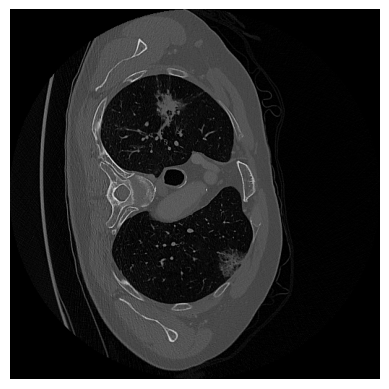

In [25]:
# class demo
lungs = LungCTDataset(TRAIN_IMAGES, TRAIN_LABELS)
image, label = lungs.__getitem__(80)

plt.imshow(image.permute(1, 2, 0).numpy(), cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

In [26]:
image.shape

torch.Size([1, 512, 512])

In [107]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ConvertImageDtype(torch.float)
])

train_dataset = LungCTDataset(image_dir=TRAIN_IMAGES, label_dir=TRAIN_LABELS, image_transform=transform, label_transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=os.cpu_count())

validation_dataset = LungCTDataset(image_dir=VALIDATION_IMAGES, label_dir=VALIDATION_LABELS, image_transform=transform, label_transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=True, num_workers=os.cpu_count())

## Model creation

### U-Net 

In [108]:
# TODO: opciona funkcija za crtanje izmedju slojeva?

Creating U-Net architecture

In [109]:
# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
        
#         # Coder
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
#         self.conv1_drop = nn.Dropout(0.1)
#         self.conv2_drop = nn.Dropout(0.1)
#         self.conv3_drop = nn.Dropout(0.2)
#         self.conv4_drop = nn.Dropout(0.2)
#         self.conv5_drop = nn.Dropout(0.3)
        
#         # Max pooling layers
#         self.pool = nn.MaxPool2d(2, 2)
        
#         # Decoder
#         self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
#         self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

#         self.conv6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)  # Adjusted channel sizes
#         self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
#         self.conv8 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
#         self.conv9 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        
#         self.final_conv = nn.Conv2d(16, 1, kernel_size=1)
        
#     def forward(self, x):
#         # Coder
#         c1 = F.relu(self.conv1(x))  # Shape: [batch_size, 16, 128, 128]
#         c1 = self.conv1_drop(c1)    # Apply dropout after activation
#         p1 = self.pool(c1)          # Shape: [batch_size, 16, 64, 64]
        
#         c2 = F.relu(self.conv2(p1)) # Shape: [batch_size, 32, 64, 64]
#         c2 = self.conv2_drop(c2)    # Apply dropout after activation
#         p2 = self.pool(c2)          # Shape: [batch_size, 32, 32, 32]
        
#         c3 = F.relu(self.conv3(p2)) # Shape: [batch_size, 64, 32, 32]
#         c3 = self.conv3_drop(c3)    # Apply dropout after activation
#         p3 = self.pool(c3)          # Shape: [batch_size, 64, 16, 16]
        
#         c4 = F.relu(self.conv4(p3)) # Shape: [batch_size, 128, 16, 16]
#         c4 = self.conv4_drop(c4)    # Apply dropout after activation
#         p4 = self.pool(c4)          # Shape: [batch_size, 128, 8, 8]
        
#         c5 = F.relu(self.conv5(p4)) # Shape: [batch_size, 256, 8, 8]
#         c5 = self.conv5_drop(c5)    # Apply dropout after activation
        
#         # Decoder
#         u6 = self.upconv1(c5)       # Shape: [batch_size, 128, 16, 16]
#         u6 = torch.cat([u6, c4], dim=1) # Concatenate along channels: Shape [batch_size, 256, 16, 16]
#         c6 = F.relu(self.conv6(u6)) # Shape: [batch_size, 128, 16, 16]
#         c6 = self.conv4_drop(c6)    # Apply dropout after activation

#         u7 = self.upconv2(c6)       # Shape: [batch_size, 64, 32, 32]
#         u7 = torch.cat([u7, c3], dim=1) # Concatenate along channels: Shape [batch_size, 128, 32, 32]
#         c7 = F.relu(self.conv7(u7)) # Shape: [batch_size, 64, 32, 32]
#         c7 = self.conv3_drop(c7)    # Apply dropout after activation

#         u8 = self.upconv3(c7)       # Shape: [batch_size, 32, 64, 64]
#         u8 = torch.cat([u8, c2], dim=1) # Concatenate along channels: Shape [batch_size, 64, 64, 64]
#         c8 = F.relu(self.conv8(u8)) # Shape: [batch_size, 32, 64, 64]
#         c8 = self.conv2_drop(c8)    # Apply dropout after activation

#         u9 = self.upconv4(c8)       # Shape: [batch_size, 16, 128, 128]
#         u9 = torch.cat([u9, c1], dim=1) # Concatenate along channels: Shape [batch_size, 32, 128, 128]
#         c9 = F.relu(self.conv9(u9)) # Shape: [batch_size, 16, 128, 128]
#         c9 = self.conv1_drop(c9)    # Apply dropout after activation

#         output = torch.sigmoid(self.final_conv(c9)) # Shape: [batch_size, 1, 128, 128]
#         return output

In [121]:
with_dropout = True
drop_prob = 0.1

class double_conv(nn.Module):
    """
    Double Convolution layer with both 2 BN and Activation Layer in between
    Conv2d==>BN==>Activation==>Conv2d==>BN==>Activation
    """

    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        # initializing the model either with or without dropout
        if with_dropout:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channel),
                nn.Dropout2d(p=drop_prob, inplace=False),
                nn.Conv2d(out_channel, out_channel, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channel),
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channel),
                nn.Conv2d(out_channel, out_channel, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channel),
            )

    def forward(self, x):
        x = self.conv(x)
        return x


class down_conv(nn.Module):
    """
    A maxpool layer followed by a Double Convolution.
    MaxPool2d==>double_conv.
    """

    def __init__(self, in_channel, out_channel):
        super(down_conv, self).__init__()
        self.down = nn.Sequential(nn.MaxPool2d(2), double_conv(in_channel, out_channel))

    def forward(self, x):
        x = self.down(x)
        return x


class up_sample(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(up_sample, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.double_conv = double_conv(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.double_conv(x)
        return x


class UNet(nn.Module):
    """Main Unet Model"""

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        ## DownSampling Block
        self.down_block1 = double_conv(in_channel, 16)
        self.down_block2 = down_conv(16, 32)
        self.down_block3 = down_conv(32, 64)
        self.down_block4 = down_conv(64, 128)
        self.down_block5 = down_conv(128, 256)
        self.down_block6 = down_conv(256, 512)
        self.down_block7 = down_conv(512, 1024)
        ## UpSampling Block
        self.up_block1 = up_sample(1024 + 512, 512)
        self.up_block2 = up_sample(512 + 256, 256)
        self.up_block3 = up_sample(256 + 128, 128)
        self.up_block4 = up_sample(128 + 64, 64)
        self.up_block5 = up_sample(64 + 32, 32)
        self.up_block6 = up_sample(32 + 16, 16)
        self.up_block7 = nn.Conv2d(16, out_channel, 1)

    def forward(self, x):
        """
        Forward of the contructed U-net
        Args:
            x: input image
        Returns:
            image object passed through the networks with pixels classified as primary or background
        """
        # Down sampling
        x1 = self.down_block1(x)
        x2 = self.down_block2(x1)
        x3 = self.down_block3(x2)
        x4 = self.down_block4(x3)
        x5 = self.down_block5(x4)
        x6 = self.down_block6(x5)
        x7 = self.down_block7(x6)
        # Up sampling
        x8 = self.up_block1(x7, x6)
        x9 = self.up_block2(x6, x5)
        x10 = self.up_block3(x9, x4)
        x11 = self.up_block4(x10, x3)
        x12 = self.up_block5(x11, x2)
        x13 = self.up_block6(x12, x1)
        x14 = self.up_block7(x13)
        out = torch.sigmoid(x14)
        return out

In [122]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, prediction, target):
        prediction_f = prediction.flatten()
        target_f = target.flatten()
        
        intersection = prediction_f * target_f
        dice_coef = (2.0 * intersection.sum() + self.smooth) / (prediction_f.sum() + target_f.sum() + self.smooth)
        
        return 1 - dice_coef

In [123]:
# Mmdel instantiation
model = UNet(1, 1)

# Check if GPU is available and move the model to GPU if possible
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# Define loss and optimizer
criterion = DiceLoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)

UNet(
  (down_block1): double_conv(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout2d(p=0.1, inplace=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down_block2): down_conv(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Dropout2d(p=0.1, inplace=False)
          (4): Conv2d(32, 32, kernel_size=(3,

## Model training

Train model:

In [124]:
#moramo da stavimo vise epoha naravno, ali nisam imala vremena da cekam 
num_epochs =  50 #25  # Number of epochs

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} started ... \n")
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # print(images[0].shape)
        
        optimizer.zero_grad()
        # print(images[0])
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)  # Calculate loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} end ... \n")
    print(f'Loss: {running_loss/len(train_loader)}')
    print('...........................................')


Epoch 1/50 started ... 

Epoch 1/50 end ... 

Loss: 0.9893969312217665
...........................................
Epoch 2/50 started ... 

Epoch 2/50 end ... 

Loss: 0.964832137460294
...........................................
Epoch 3/50 started ... 

Epoch 3/50 end ... 

Loss: 0.6908677890434028
...........................................
Epoch 4/50 started ... 

Epoch 4/50 end ... 

Loss: 0.5098124139057183
...........................................
Epoch 5/50 started ... 

Epoch 5/50 end ... 

Loss: 0.4501321430532088
...........................................
Epoch 6/50 started ... 

Epoch 6/50 end ... 

Loss: 0.4532091832309036
...........................................
Epoch 7/50 started ... 

Epoch 7/50 end ... 

Loss: 0.41195737575151903
...........................................
Epoch 8/50 started ... 

Epoch 8/50 end ... 

Loss: 0.3877781074239601
...........................................
Epoch 9/50 started ... 

Epoch 9/50 end ... 

Loss: 0.3531571226830808
.........

Save model: 

In [125]:
#Enter name of the model:
model_name = input()

 model_diceLoss_50epochs


In [126]:
torch.save(model.state_dict(), 'models/'+model_name+'.pth')

## Model evaluation and visualization

In [128]:
# moramo dodati racunanje loss-a i tako to ali to cemo tek kad postan emalo pametniji hahaha
def evalModel(model, loader, display_size= 16):
    model.eval()  # Set to evaluation mode

    # Get a batch of test data
    images, masks = next(iter(loader))
    images = images.to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(images)
    
    # Plot the results
    for i in range(display_size):  # Display the first display_size images
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].permute(1, 2, 0), cmap='gray')  # Original image
        plt.title("Input Image")
        
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i][0], cmap='gray')  # Ground truth mask
        plt.title("Ground Truth Mask")
        
        plt.subplot(1, 3, 3)
        plt.imshow(outputs[i][0], cmap='gray')  # Predicted mask
        plt.title("Predicted Mask")
        
        plt.show()


### Train data:

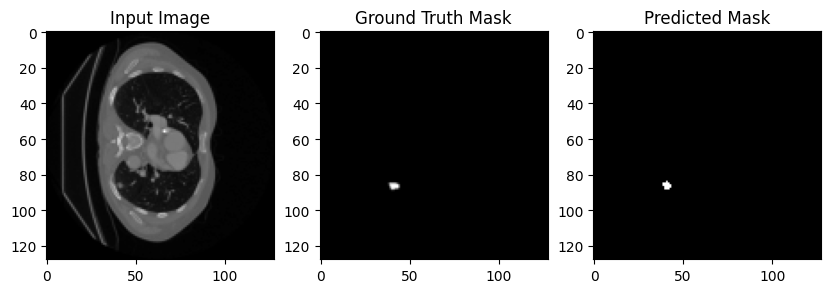

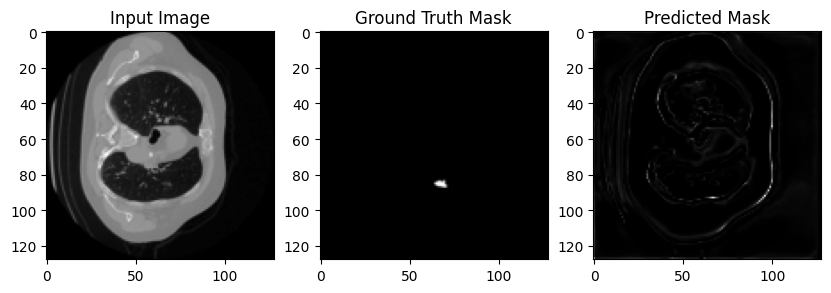

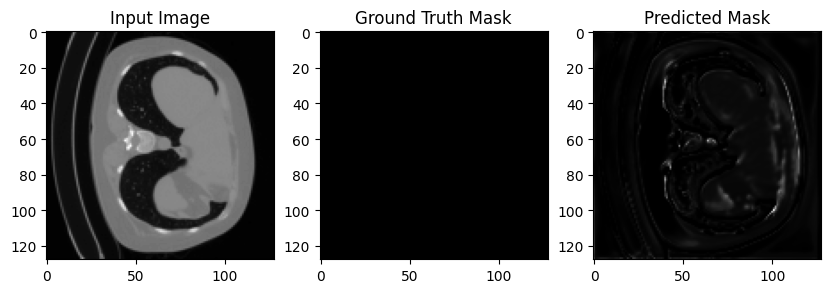

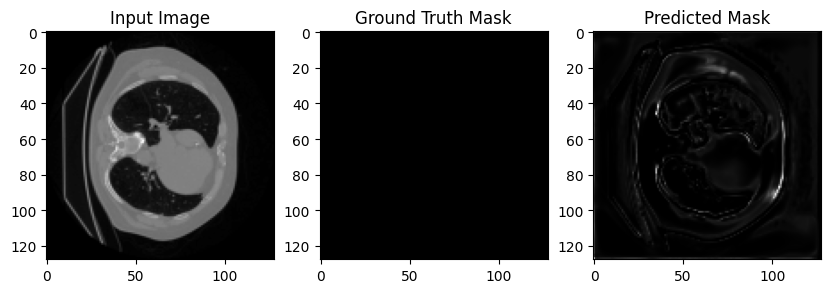

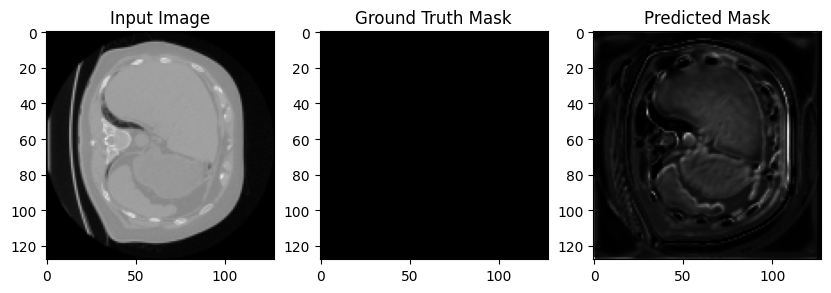

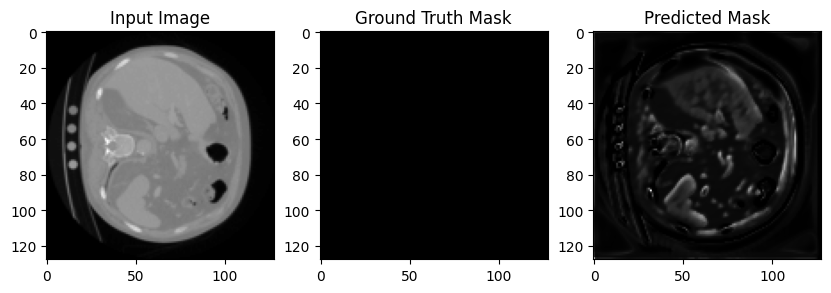

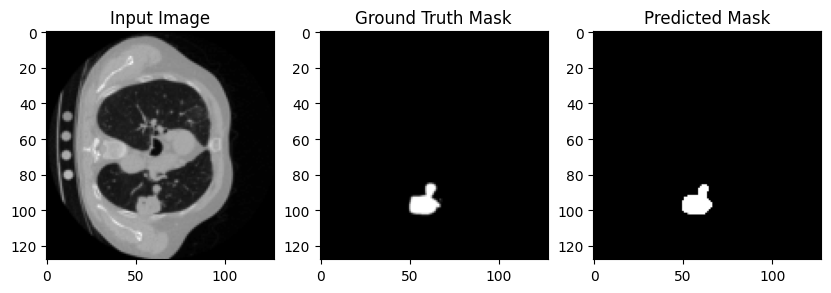

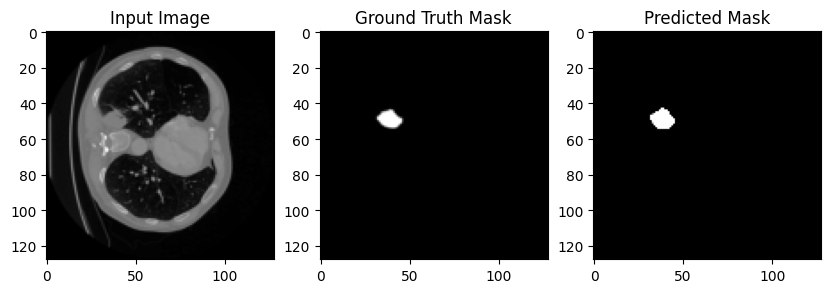

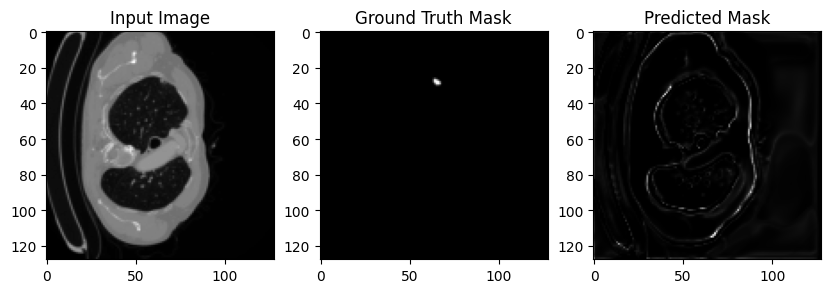

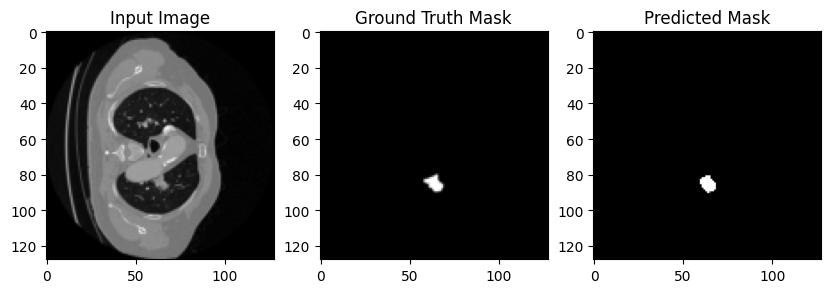

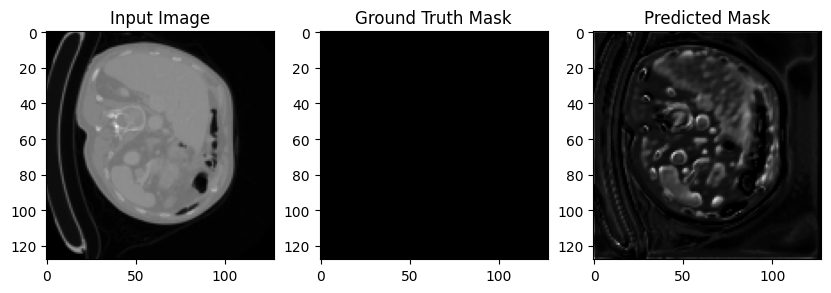

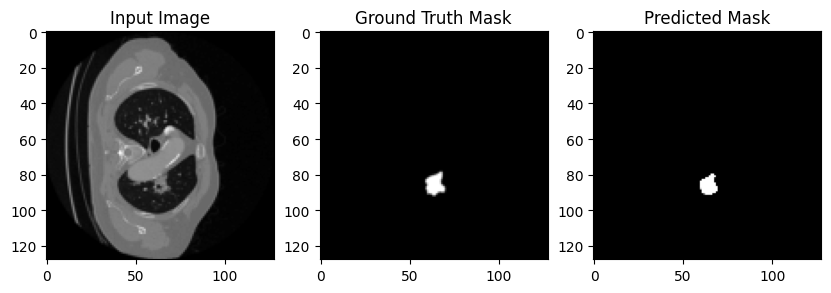

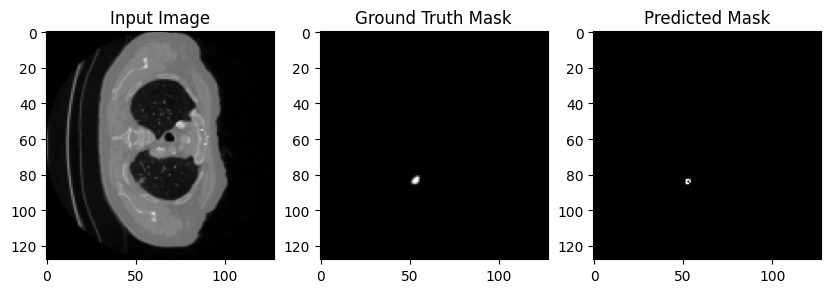

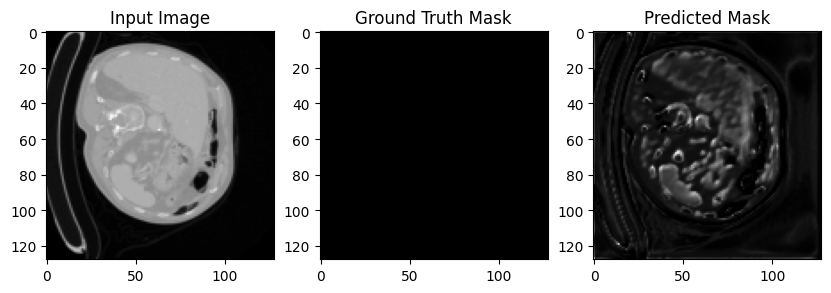

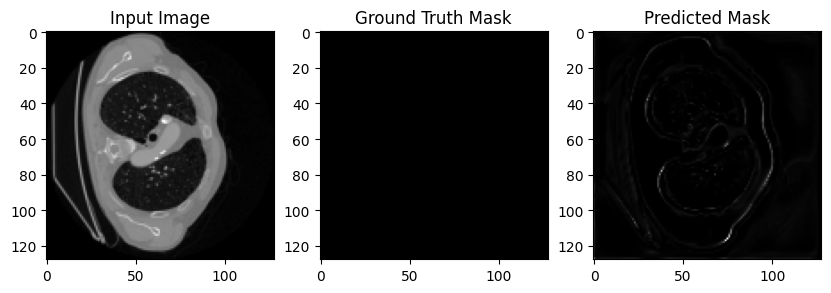

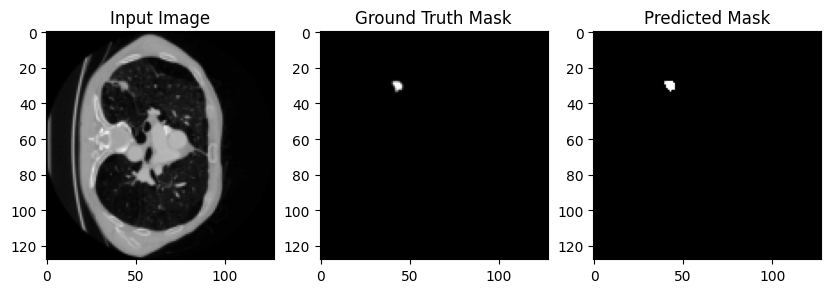

In [129]:
evalModel(model, train_loader)

### Valiadtion data:

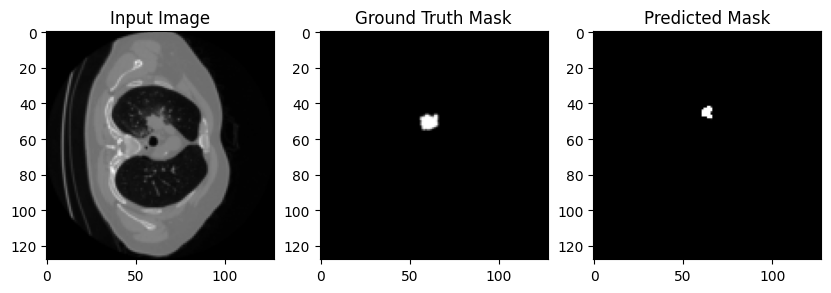

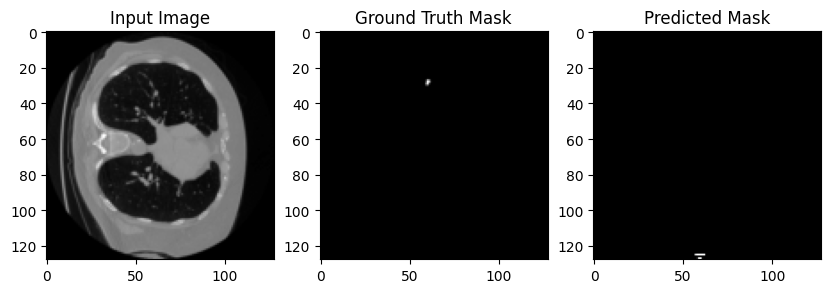

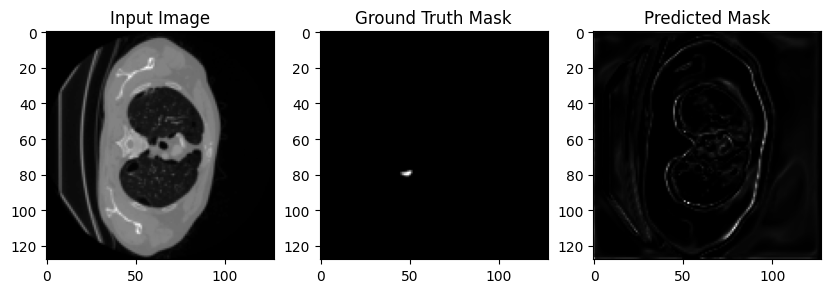

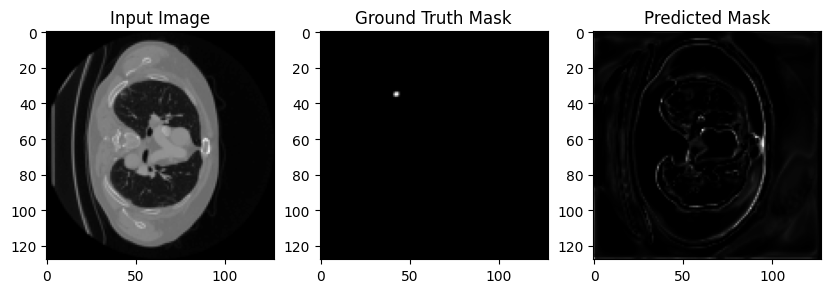

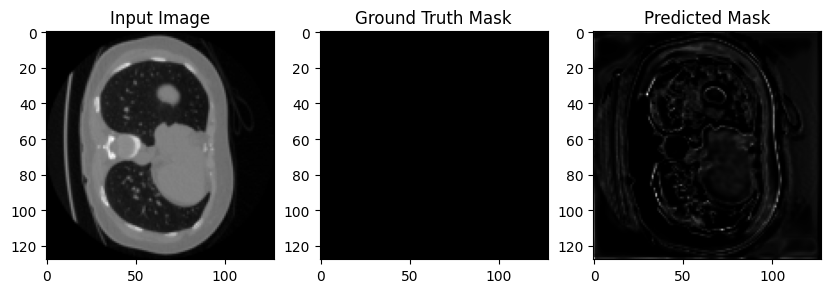

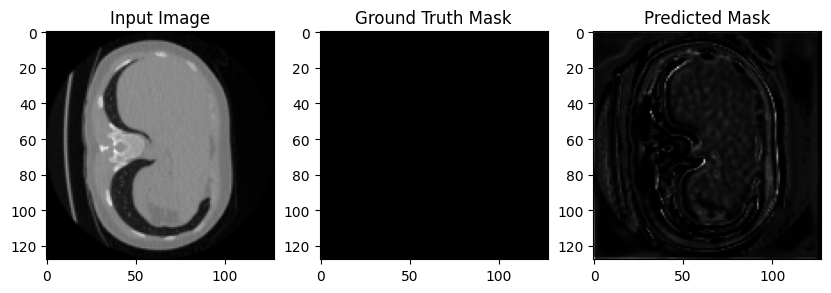

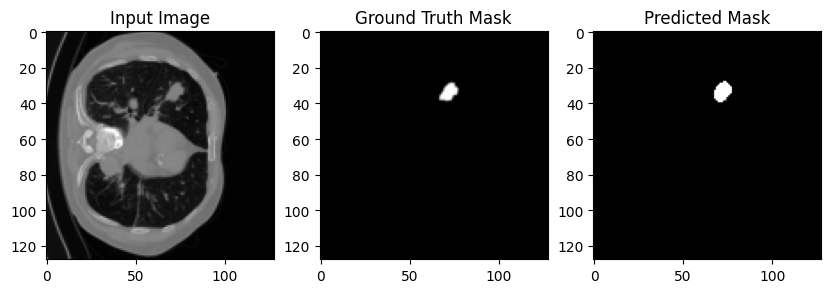

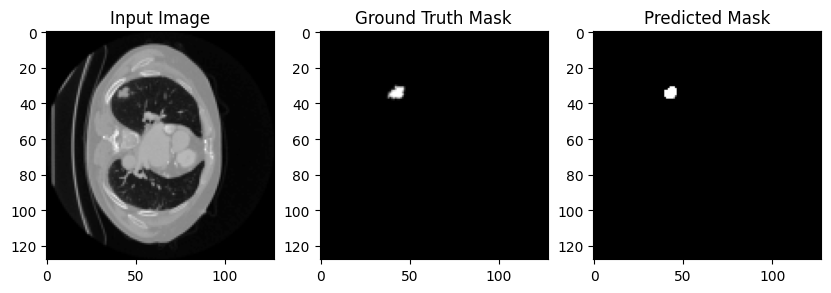

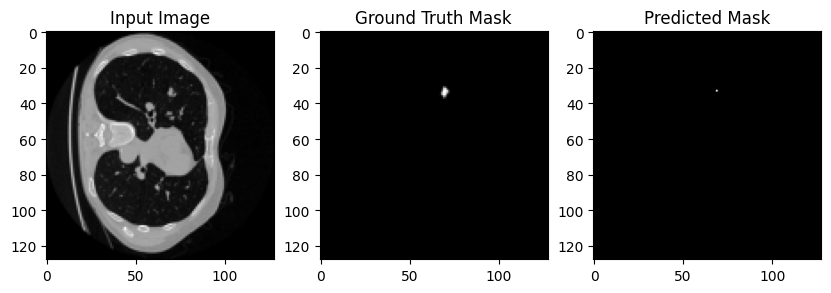

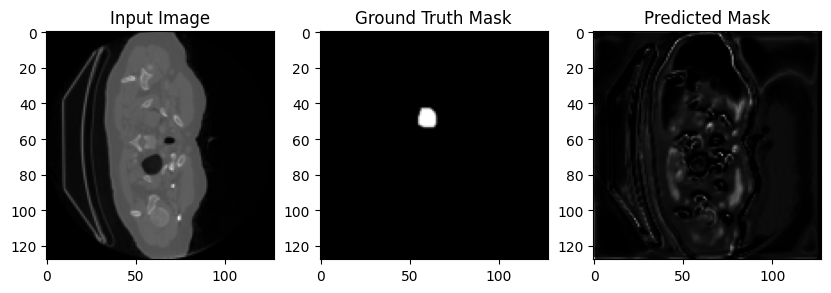

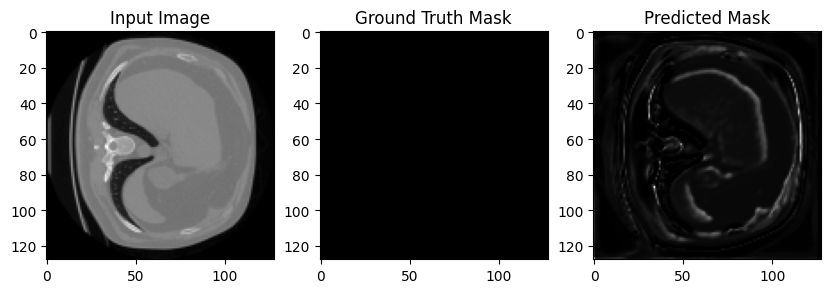

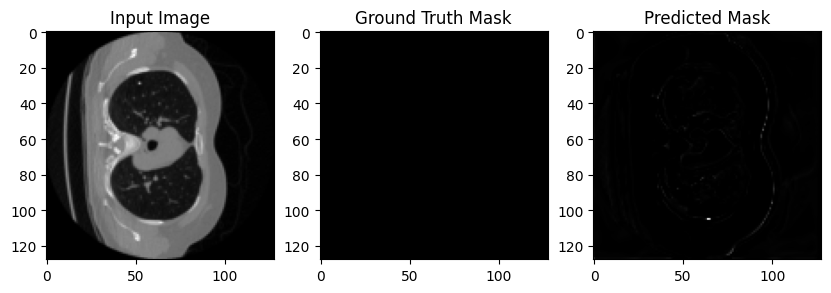

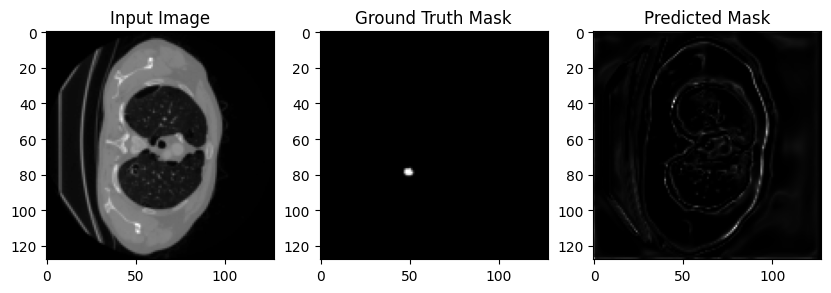

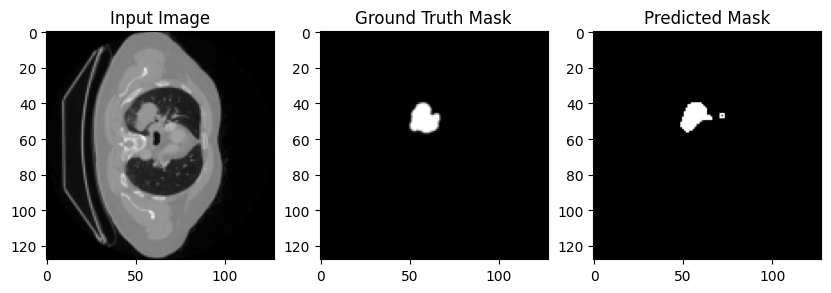

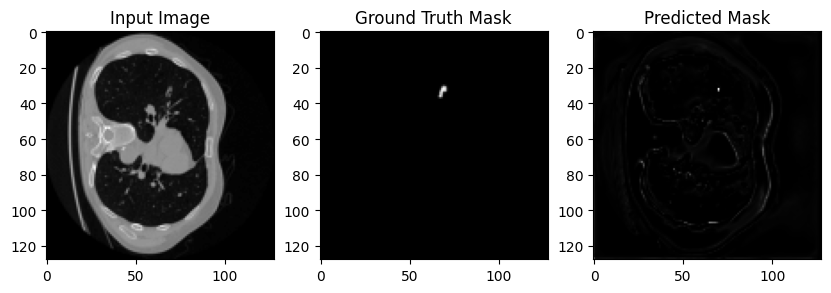

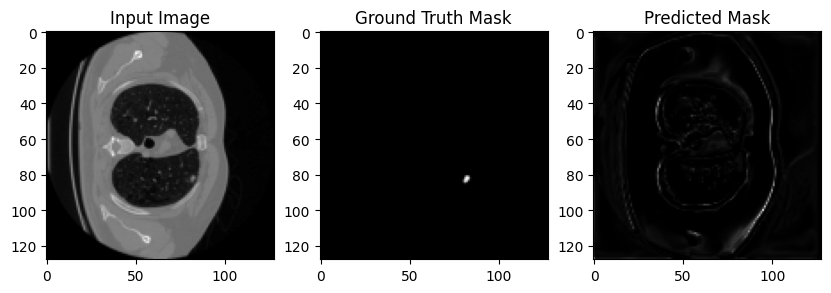

In [130]:
evalModel(model, validation_loader)

Testing:

## References

1. U-Net: Convolutional Networks for Biomedical Image Segmentation: Olaf Ronneberger, Philipp Fischer, and Thomas Brox - Computer Science Department and BIOSS Centre for Biological Signalling Studies, University of Freiburg, Germany